# Final project COGS 118B


## Part 1: Data


In [3]:
#from google.colab import files
import io
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=2, style="white")
from sklearn import preprocessing 
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import pygal
from pygal.style import Style

plt.rcParams['figure.figsize'] = (12, 5)

In [4]:
# Upload data
#uploaded = files.upload()

In [5]:
# Convert the data into Pandas dataframe
#df = pd.read_csv(io.BytesIO(uploaded['Country-data.csv']))
df = pd.read_csv ('Country-data.csv')
df.head()
# Dataset is now stored in a Pandas Dataframe

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Part 2: K-means clustering

### 2.1 Without scaling the features

In [6]:
# Convert the data into numpy array
dfArray = df.to_numpy()

In [7]:
# Look at data
dfArray.shape # data shape 167x10
dfArray[0:,:] # columns are: Name, child_mort, exports, health, imports, income, inflation, life_expec, total_fer, gdpp.

array([['Afghanistan', 90.2, 10.0, ..., 56.2, 5.82, 553],
       ['Albania', 16.6, 28.0, ..., 76.3, 1.65, 4090],
       ['Algeria', 27.3, 38.4, ..., 76.5, 2.89, 4460],
       ...,
       ['Vietnam', 23.3, 72.0, ..., 73.1, 1.95, 1310],
       ['Yemen', 56.3, 30.0, ..., 67.5, 4.67, 1310],
       ['Zambia', 83.1, 37.0, ..., 52.0, 5.4, 1460]], dtype=object)

In [8]:
# Remove first column with the country names 
dfArray_Values = dfArray[:,1:]

In [9]:
# Convert datapoints to float 
dfArray_Values = np.array(list(dfArray_Values), dtype=float)

In [10]:
def calcSqDistances(X, Kmus):
  sqDist = ((-2 * X.dot(Kmus.T) + np.sum(np.multiply(Kmus,Kmus), axis = 1).T).T + np.sum(np.multiply(X,X), axis = 1)).T
  return sqDist

In [11]:
def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis = 1)
    Rnk = np.eye(sqDmat.shape[1])[m]
    return Rnk

In [12]:
def recalcMus(X, Rnk):
    N,D = X.shape 
    Kmus_new = (np.divide(X.T.dot(Rnk),np.sum(Rnk,axis = 0))).T
    
    return Kmus_new

In [13]:
def runKMeans(K, data):
    X = data
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        sqDmat = calcSqDistances(X, Kmus)
        Rnk = determineRnk(sqDmat)
        KmusOld = Kmus
        
        Kmus = recalcMus(X, Rnk)
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-12:
            print('Number of iterations running K-means: ', iter)
            break

    return Rnk

In [14]:
# Create a list of list
def createListofList(cluster_locations):
  tempList = []

  for i in range(np.size(cluster_locations, axis = 1)):
      tempList.append([])

  return tempList

In [15]:
# Get a list of cluster with each element being a cluster list
def getClusters(cluster_locations, dfArray):
    
    cluster_Lists = createListofList(cluster_locations)
    
    for i in range(len(dfArray[:,0])):
      for j in range(np.size(cluster_locations, axis = 1)):
        if cluster_locations[i,j] == 1:
          cluster_Lists[j].append(dfArray[i,0])

    return cluster_Lists

In [16]:
def displayCluster(string,cluster_locations, dfArray, file_name_svg): # WORLD MAP FUNCTION
    countries_ab = pd.read_csv('countries_ab.csv')
   # countries_ab
    countries_ab_new = countries_ab.to_numpy()
    cluster_Lists = getClusters(cluster_locations, dfArray)

    # THESE ARE THE CHARACTER CODES FOR EACH CLUSTER NAMES
    cluster_new = createListofList(cluster_locations)

#print(countries_ab_new[:,0])

    # THESE ARE THE CHARACTER CODES FOR EACH CLUSTER NAMES
    cluster_new = []
# Iterate over a sequence of numbers from 0 to 4
    for i in range(np.size(cluster_locations,axis =1)):
    # In each iteration, add an empty list to the main list
        cluster_new.append([])

    for i in range(len(countries_ab_new[:,0])):
        for j in range(np.size(cluster_locations, axis = 1)):
            if countries_ab_new[i,1] in cluster_Lists[j]:
                cluster_new[j].append(countries_ab_new[i,0])

    #create a Style object
    custom_style = Style( colors = ('#FF0000' , '#0000FF' ,'#00FF00' , '#000000'))

    # the custom colours in the map,
    worldmap = pygal.maps.world.World(style = custom_style)

    # set the title of the map
    worldmap.title = string

    for i in range(np.size(cluster_locations, axis = 1)):
        worldmap.add('Cluster: %i'%(i + 1) , cluster_new[i]) # CHARACTER CODES FROM BEFORE

    # save into the file
    worldmap.render_to_file(file_name_svg)

    print("Success")

In [ ]:
cluster_locations = runKMeans(3, dfArray_Values)

displayCluster("Countries without scaling",cluster_locations, dfArray,'countries_without_scaling.svg' )
from IPython.core.display import SVG
SVG(filename='countries_without_scaling.svg')

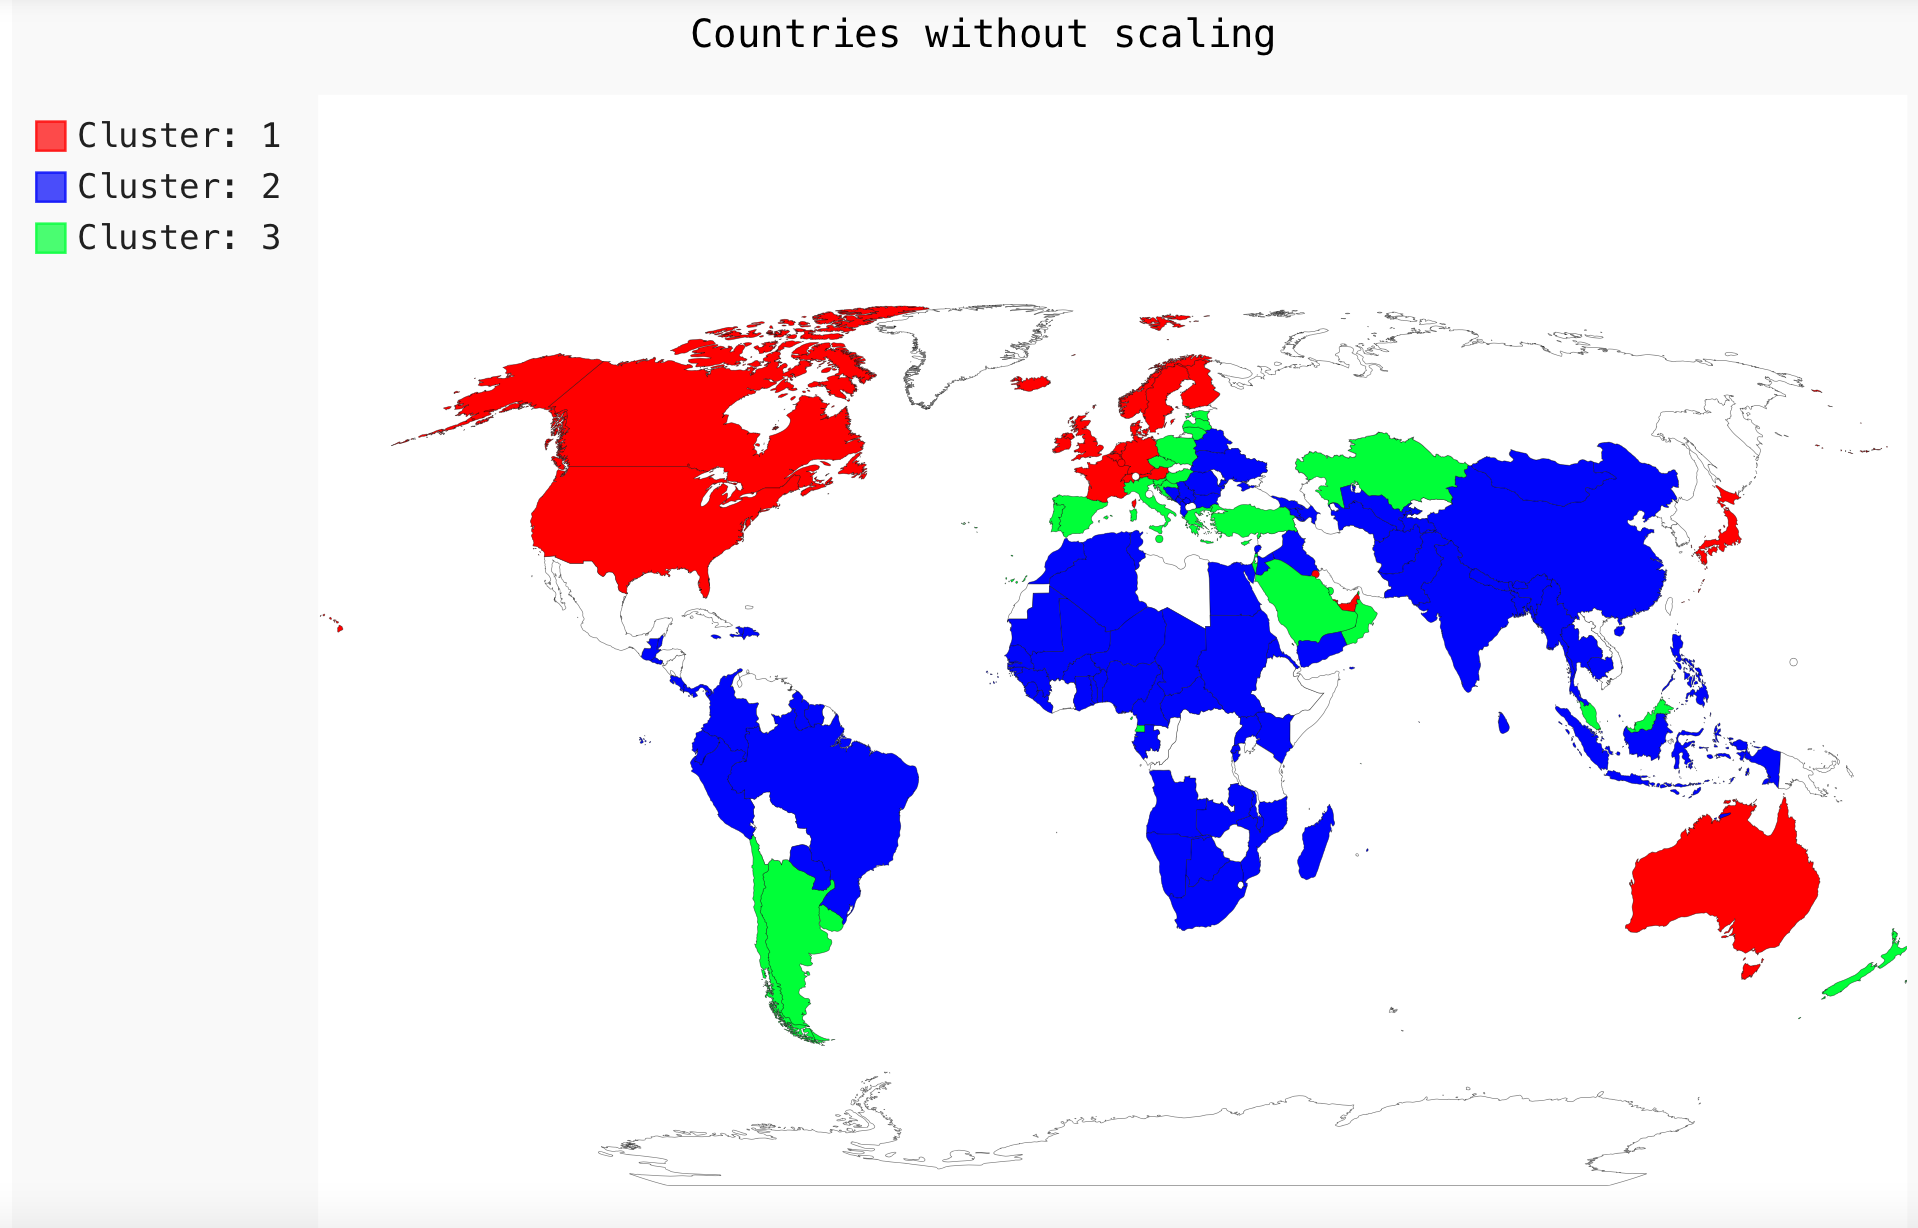

### 2.2 With scaling

In [18]:
# We drop the labels in the pandas dataframe too
df2 = df.drop('country', axis=1)
df2.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [19]:
# Standard scale the data to avoid features with large values having large impact
# numpy array
dfArray_Normal = preprocessing.scale(df2)

# Transforming normalized data into panda dataframe: Used for plotting
# panda dataframe
df_Normalized = pd.DataFrame(dfArray_Normal,columns= df2.columns)


In [ ]:
# Run K-means on scaled data
cluster_LocNormal = runKMeans(3, dfArray_Normal)
displayCluster("Countries after scaling",cluster_LocNormal, dfArray, 'countries_after_scaling.svg')
from IPython.core.display import SVG
SVG(filename='countries_after_scaling.svg')

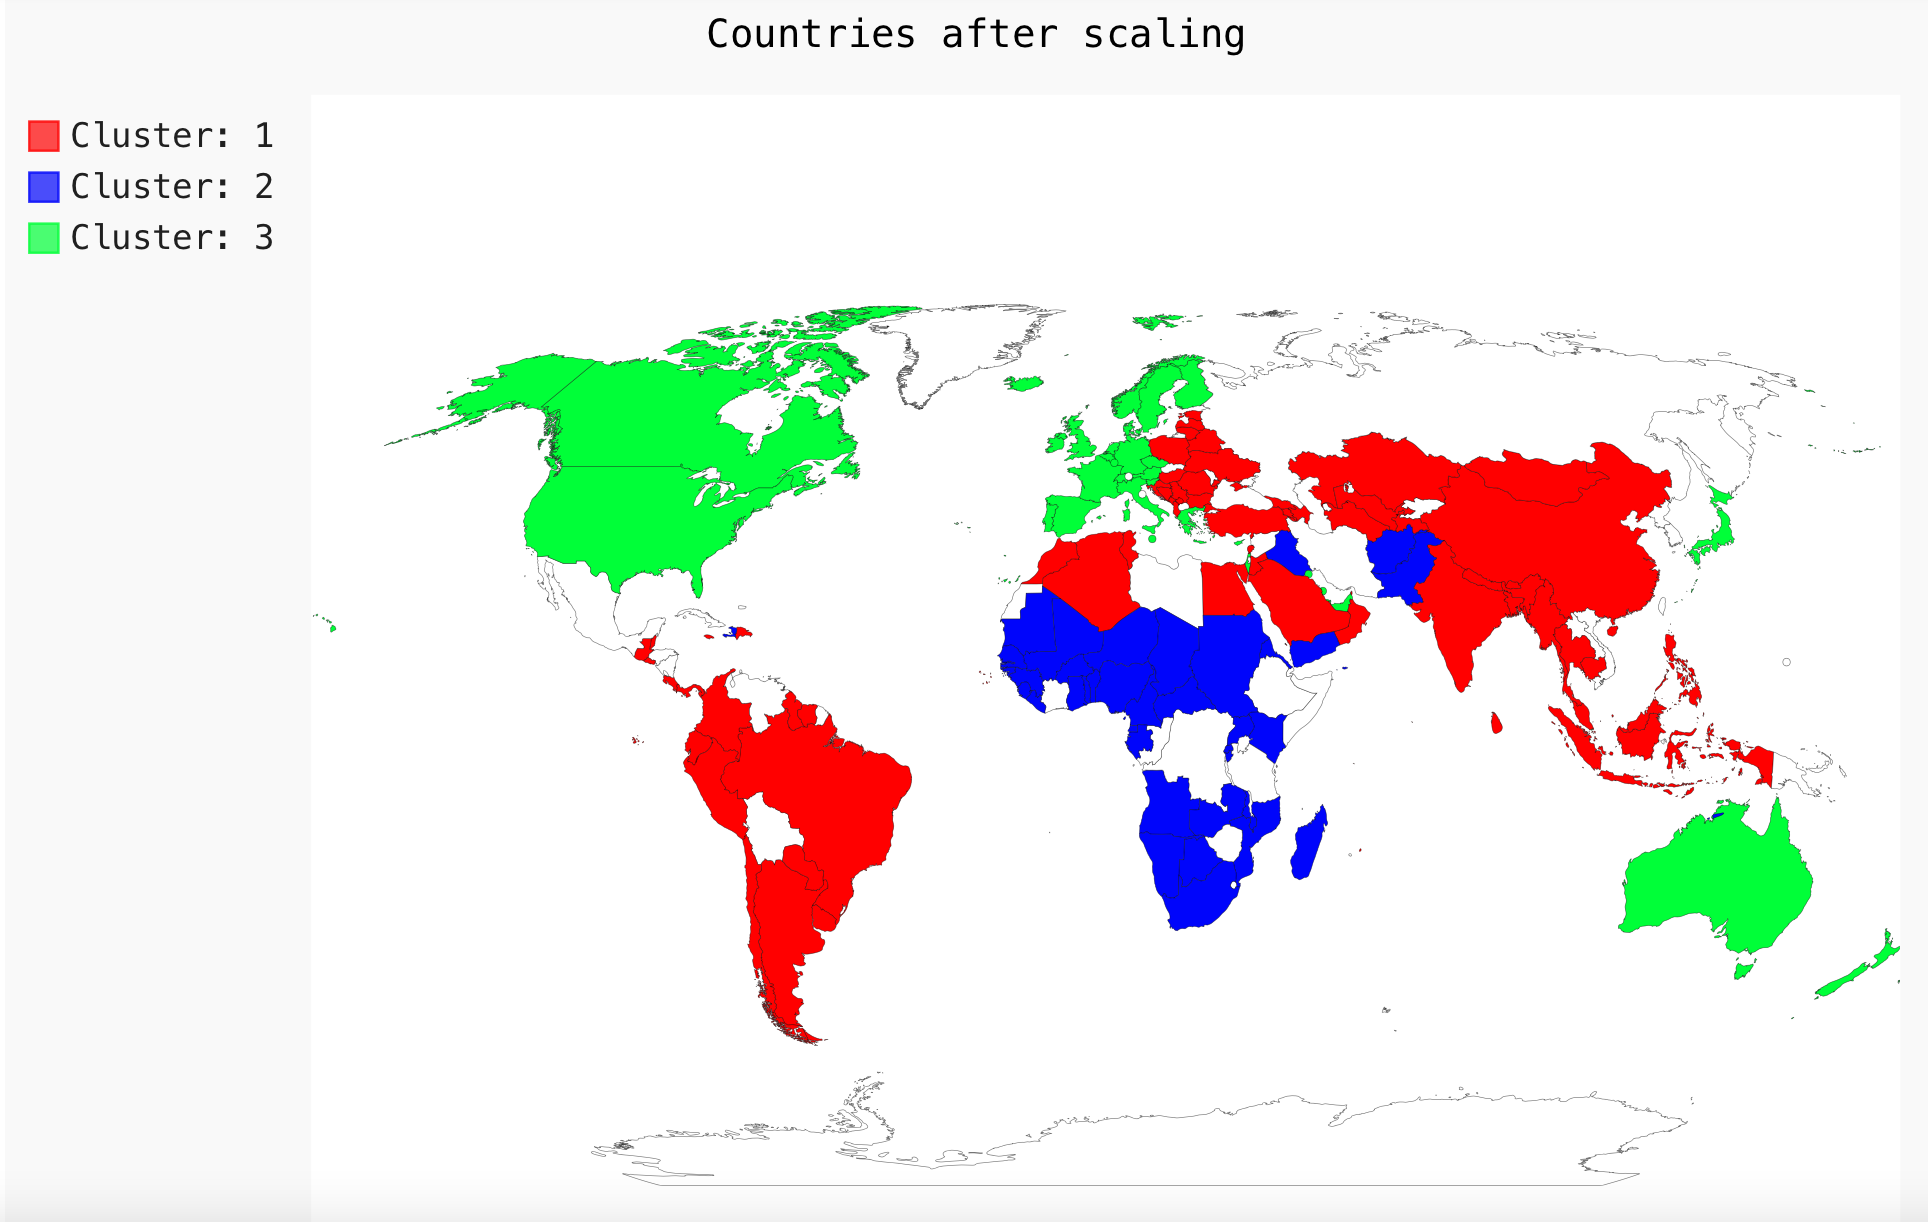

In [21]:
# Get an array with the cluster locations

def getClusterIndex(cluster_LocNormal):
  # Create empty matrix 
  n,k = cluster_LocNormal.shape
  cluster_index = np.zeros((n), dtype = np.int32)

  # Create cluster matrix 
  for i in range(len(cluster_LocNormal)):
    for cluster in range(k):
      if cluster_LocNormal[i,cluster] == 1:
        cluster_index[i]=cluster

  return cluster_index

In [22]:
# Create empty matrix 
cluster_IndNormal = getClusterIndex(cluster_LocNormal)

In [23]:
# Add cluster column
df_Normalized['clusters']= cluster_IndNormal + 1

[Text(0.5, 1.0, 'Clustering by Income and GDPP')]

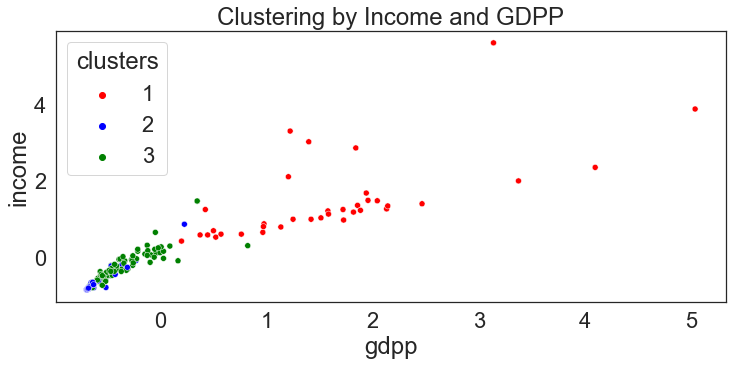

In [24]:
# Plot
# after scaling
# clustering by income and gdpp
sns.scatterplot(x= 'gdpp', y='income', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Income and GDPP')

[Text(0.5, 1.0, 'Clustering by Health and GDPP')]

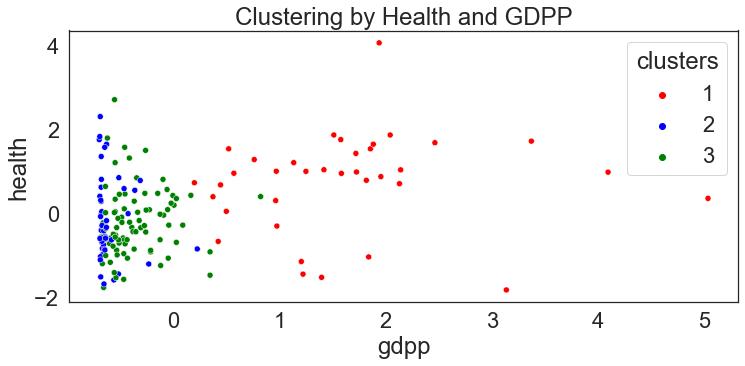

In [25]:
# Clustering by health and gdpp
sns.scatterplot(x= 'gdpp', y='health', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Health and GDPP')

[Text(0.5, 1.0, 'Clustering by Inflation and GDPP')]

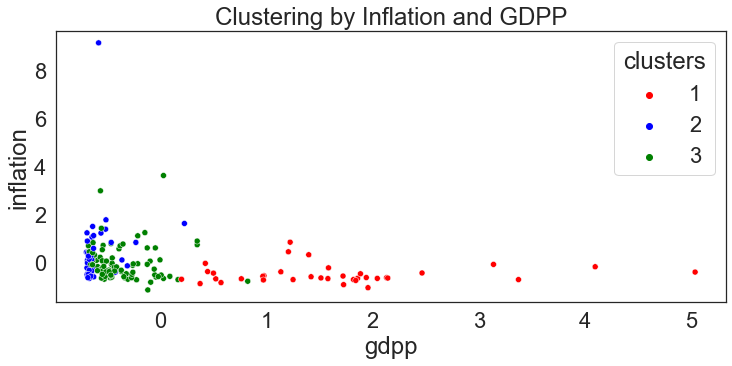

In [26]:
# clustering by inflation and gdpp
sns.scatterplot(x= 'gdpp', y='inflation', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Inflation and GDPP')

[Text(0.5, 1.0, 'Clustering by Exports and Imports')]

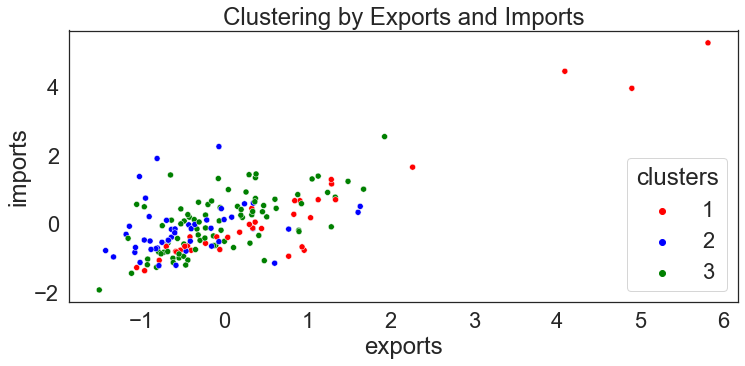

In [27]:
# Clustering by exports and imports
sns.scatterplot(x= 'exports', y='imports', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Exports and Imports')

[Text(0.5, 1.0, 'Clustering by Life Expectancy and Health')]

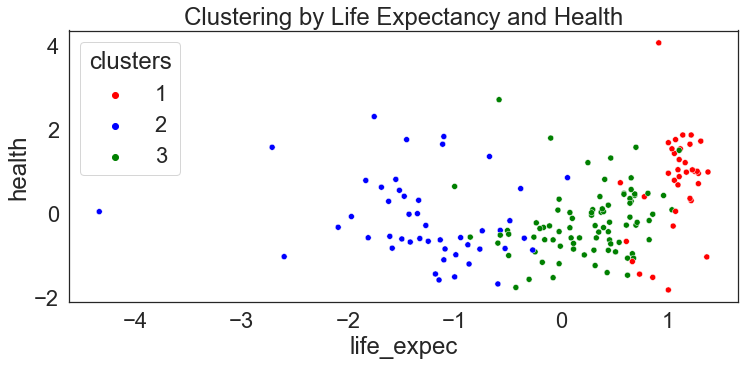

In [28]:
# Clustering by by life expectancy and health
sns.scatterplot(x= 'life_expec', y='health', hue='clusters', 
                data=df_Normalized, palette=['red','blue','green']).set(title='Clustering by Life Expectancy and Health')

## Part C: PCA

### Number of dimensions needed

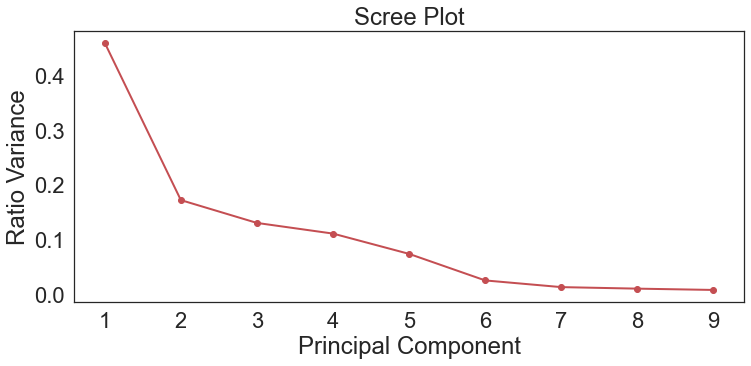

In [29]:
# Using scaled data for PCA
pca=PCA(n_components=9).fit(dfArray_Normal)
PC_values = np.arange(pca.n_components) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Ratio Variance')
plt.show()

### PCA to reduce dimensions

In [ ]:
# Run PCA -> reduces dimensions
pca = PCA(n_components = 5)

principalComp = pca.fit_transform(dfArray_Normal)
principalDf = pd.DataFrame(data = principalComp)
principalDfNP = principalDf.to_numpy()
cluster_LocPCA = runKMeans(3, principalDfNP)

displayCluster("5 components PCA clustering",cluster_LocPCA, dfArray, 'PCA_clusters.svg')
from IPython.core.display import SVG
SVG(filename='PCA_clusters.svg')

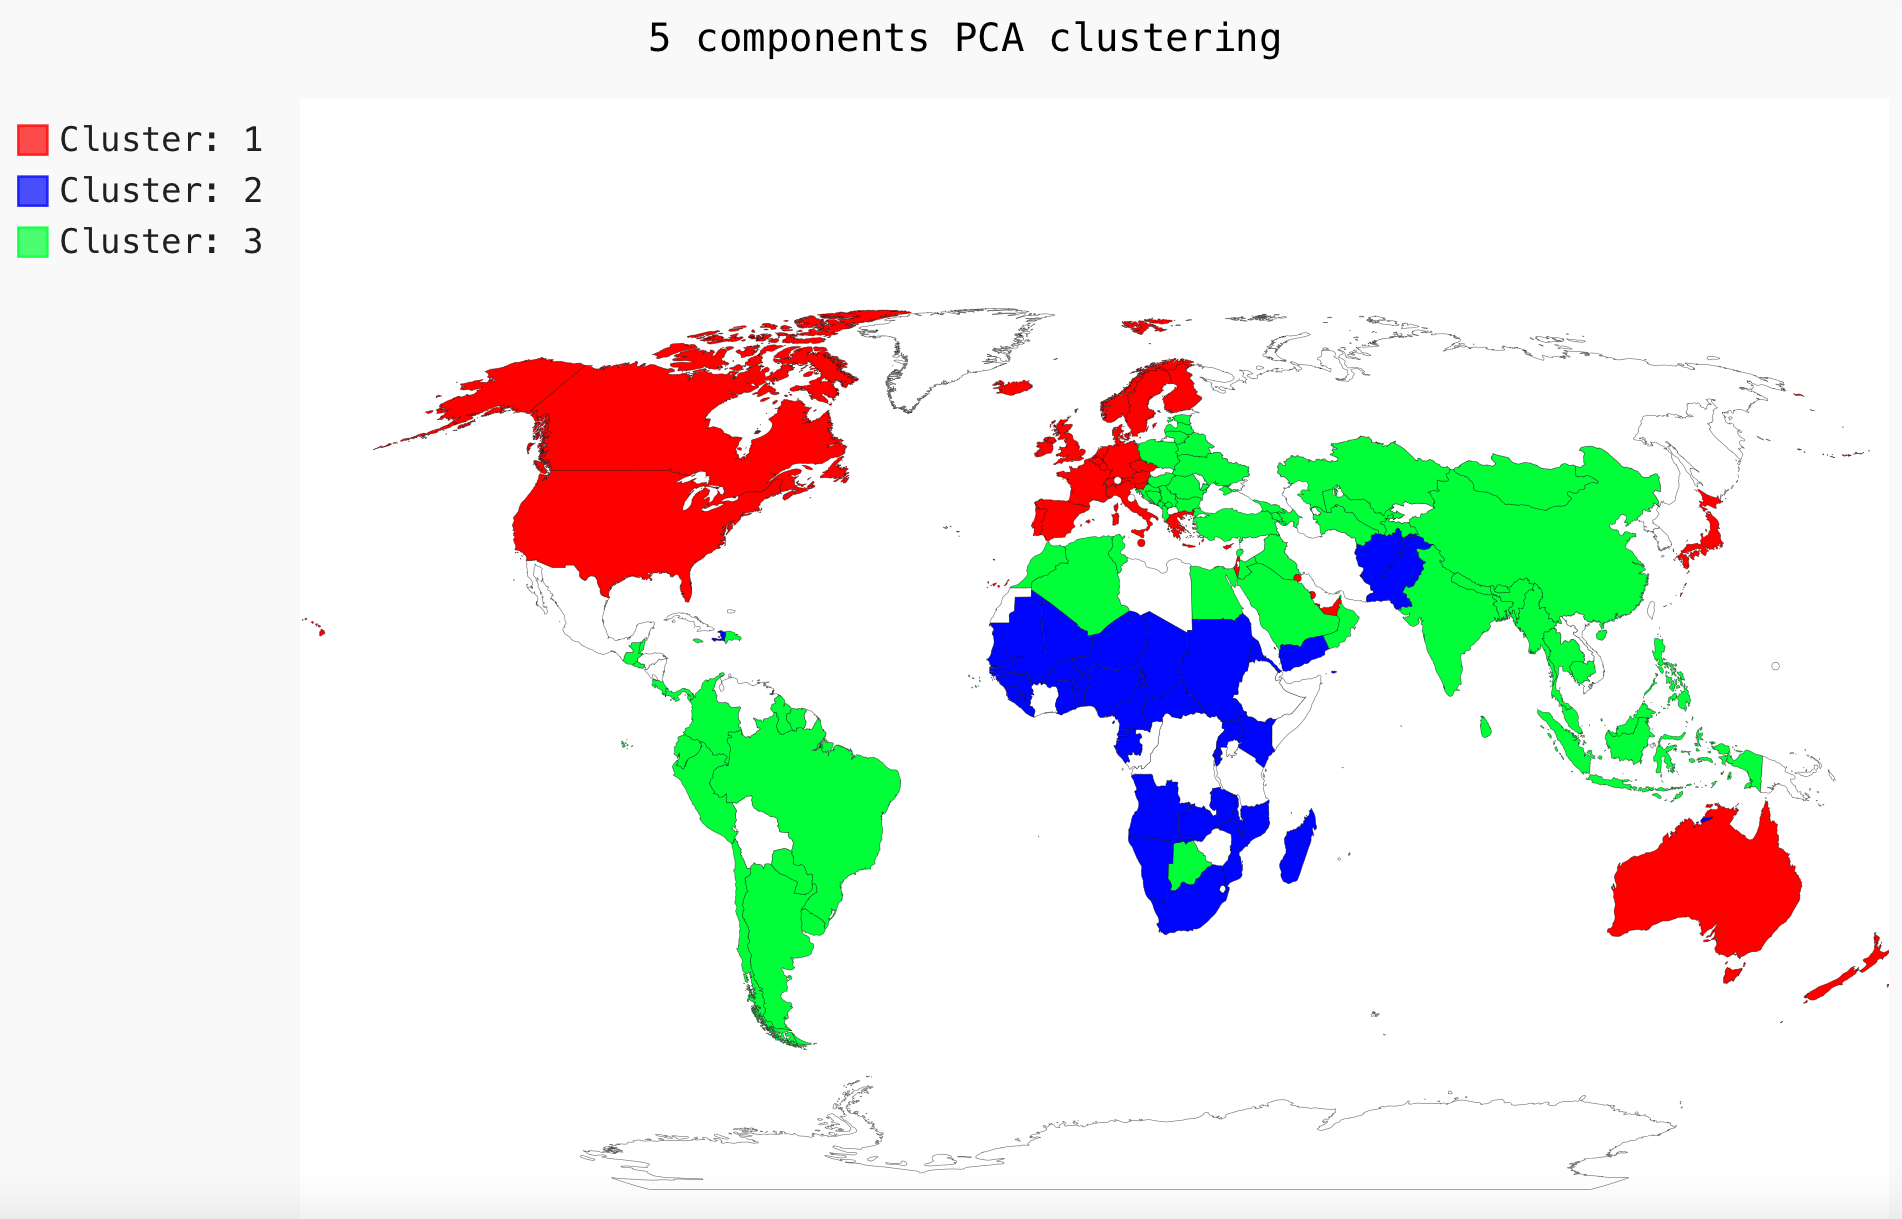